# Estimating the Nelson-Siegel Model
## Based on 3.2 (Nelson & Siegel (1987) and Diebold & Li (2006))

Based on Diebold & Li (2006), the yield curve can be modelled as:

<font size='4'>

$
y_t(\tau) = \beta_{1t}(1) + \beta_{2t}\left(\frac{1 - e^{-\lambda_t\tau}}{\lambda_t\tau}\right) + \beta_{3t}\left(\frac{1 - e^{-\lambda_t\tau}}{\lambda_t\tau} - e^{-\lambda_t\tau}\right)
$
    
</font>

Where $y_t(\tau)$ is the yield at time $t$ corresponding to maturity $\tau$. $\lambda_t$ is the time-decay parameter. Specifically, $\lambda_t$ can be freely chosen (over a grid of possible values) to produce the best overall fit.

The $\beta$'s are interpreted as 3 latent dynamic factors. 

The loading on the first factor is 1, and hence does not decay with maturity. This is thus the level/long-term factor. The loading on the second factor starts at 1 and decays rather quickly to 0, and hence can be interpreted as the short-term factor. The loading on the third factor starts at 0, increases, and ends at 0, and hence can be interpreted as the medium-term factor. 

In [278]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Data
Textbook data is used (temporarily). These are zero-yields, with maturities starting at 3 months, and yearly increments from 12 months to 120 months, spanning from 1975 to 2018.

From Diebold and Li (2006):

*"
We use end-of-month price quotes (bid-ask average) for U.S. Treasuries, from
January 1985 through December 2000, taken from the CRSP government bonds
files. CRSP filters the data, eliminating bonds with option features (callable and
flower bonds), and bonds with special liquidity problems (notes and bonds with less
than one year to maturity, and bills with less than one month to maturity), and then
converts the filtered bond prices to unsmoothed Fama and Bliss (1987) forward
rates. Then, using programs and CRSP data kindly supplied by Rob Bliss, we
convert the unsmoothed Fama–Bliss forward rates into unsmoothed Fama–Bliss
zero yields.
\
Although most of our analysis does not require the use of fixed maturities, doing
so greatly simplifies our subsequent forecasting exercises. Hence we pool the
data into fixed maturities. Because not every month has the same maturities
available, we linearly interpolate nearby maturities to pool into fixed maturities
of 3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 60, 72, 84, 96, 108, and 120 months, where a
month is defined as 30.4375 days. Although there is no bond with exactly 30.4375
days to maturity, each month there are many bonds with either 30, 31, 32, 33, or 34
days to maturity. Similarly we obtain data for maturities of 3 months, 6 months,
etc.
"*

In [2]:
data = pd.read_excel("textbook_data.xlsx", header=3, index_col=0)
data = data.filter(regex="^US_Y[0-9].*") # monthly US zero-rates
data.columns = data.columns.str.replace('US_Y','y')
data.index = data.index.rename("Date")

In [3]:
data

,y3,y12,y24,y36,y48,y60,y72,y84,y96,y108,y120
Date,,,,,,,,,,,
1975-01-31,6.206589,6.238884,6.670026,6.910766,7.041402,7.120725,7.173689,7.211528,7.239907,7.261980,7.279638
1975-02-28,6.090830,5.916754,6.278823,6.594526,6.800582,6.934522,7.025900,7.091580,7.140920,7.179310,7.210025
1975-03-31,6.007056,6.241704,6.757098,7.029764,7.176597,7.265656,7.325112,7.367588,7.399445,7.424224,7.444046
1975-04-30,6.066437,6.791323,7.412003,7.642909,7.758730,7.828228,7.874560,7.907654,7.932475,7.951780,7.967224
1975-05-30,5.348095,6.106194,6.781078,7.132689,7.327140,7.446369,7.526196,7.583260,7.626064,7.659356,7.685990
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,2.102200,2.454839,2.619778,2.681681,2.716117,2.743053,2.767769,2.791431,2.814080,2.835515,2.855561
2018-09-28,2.191995,2.620719,2.801011,2.866557,2.903993,2.933405,2.959735,2.984103,3.006661,3.027382,3.046260
2018-10-31,2.275757,2.694127,2.860678,2.915822,2.950248,2.983280,3.017837,3.053180,3.088082,3.121574,3.153050


#### Descriptive Statistics

In [421]:
stats = pd.DataFrame()
stats["Mean"] = data.mean()
stats["Std Dev"] = data.std()
stats["rho_1"] = [data[i].autocorr(lag=1) for i in data.columns.values]

stats

,Mean,Std Dev,rho_1
y3,4.819771,3.637593,0.989768
y12,5.061083,3.659536,0.991897
y24,5.312132,3.598761,0.992768
y36,5.521580,3.510411,0.993418
y48,5.702790,3.418672,0.993811
y60,5.861767,3.332164,0.994015
y72,6.001760,3.253975,0.994105
y84,6.124992,3.184953,0.994136
y96,6.233261,3.124966,0.994136
y108,6.328149,3.073437,0.994121


### Estimating the Yield Curve
The parameters $(\beta_{1t}, \beta_{2t}, \beta_{3t}, \lambda_t)$ could be estimated via non-linear least squares for each month $t$.

However the standard pratice of Nelson and Siegel (1987) is to fix $\lambda_t$ (allowing us to compute the factor loadings) and use OLS to estimate the factors ($\beta$'s) at each month. This is numerically easier than non-linear optimization. 

$\lambda_t$ is chosen such that the loading on the curvature factor is maximized for the 2 year maturity.

Specifically, we need to chose $\lambda_t$ to maximize:

<font size='4'>
$
\left(\frac{1 - e^{-\lambda_t\tau}}{\lambda_t\tau} - e^{-\lambda_t\tau}\right)
$
</font>

When $\tau = 24$.

#### Chosing $\lambda$

In [5]:
def curvature(lamb, tau):
    '''
    Function used to compute the factor loading on the curvature factor.
    '''
    e = np.exp(-lamb*tau)
    
    x = (1 - e)/(lamb*tau) - e
    
    return -x # minimize the negative

In [17]:
from scipy.optimize import minimize
obj = minimize(curvature, x0=np.array([0.075]), method="nelder-mead", args=(24))
obj

 final_simplex: (array([[0.07470703],
       [0.07476563]]), array([-0.2984256 , -0.29842556]))
           fun: -0.2984256039102821
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 7
        status: 0
       success: True
             x: array([0.07470703])

Thus we can see that $\lambda_t$ should be approximately 0.0747.

In [18]:
lambda_t = obj.x[0]

#### Loadings

In [8]:
def loadings(tau, lamb=lambda_t):
    '''
    Function to generate loadings
    '''
    
    e = np.exp(-lamb*tau)
    
    B1 = 1
    B2 = (1 - e)/(lamb*tau)
    B3 = (1 - e)/(lamb*tau) - e
    
    return [B1,B2,B3]

In [9]:
maturities = np.insert(np.linspace(12,120,10), 0, 3)

loadings_df = pd.DataFrame([loadings(t) for t in maturities], index=maturities, columns=['B1','B2','B3'])

In [419]:
def loadings_plot(loadings=loadings_df):
    fig, ax = plt.subplots(figsize=(14, 10))

    ax = loadings['B1'].plot(ax=ax, legend=True,label="\u03B21 ('Level')", color='royalblue', linewidth=2)
    ax = loadings['B2'].plot(ax=ax, legend=True,label="\u03B22 ('-Slope')", color='firebrick', linewidth=2)
    ax = loadings['B3'].plot(ax=ax, legend=True,label="\u03B23 ('Curvature')", color='blueviolet', linewidth=2)
    ax.set_title("Factor Loadings", fontsize=20)
    ax.legend(fontsize=16)
    ax.set_xlabel("")
    ax.set_yticks(ax.get_yticks())
    y_labels = ax.get_yticks()
    ax.set_yticklabels([f'{x:0.1f}' for x in y_labels])

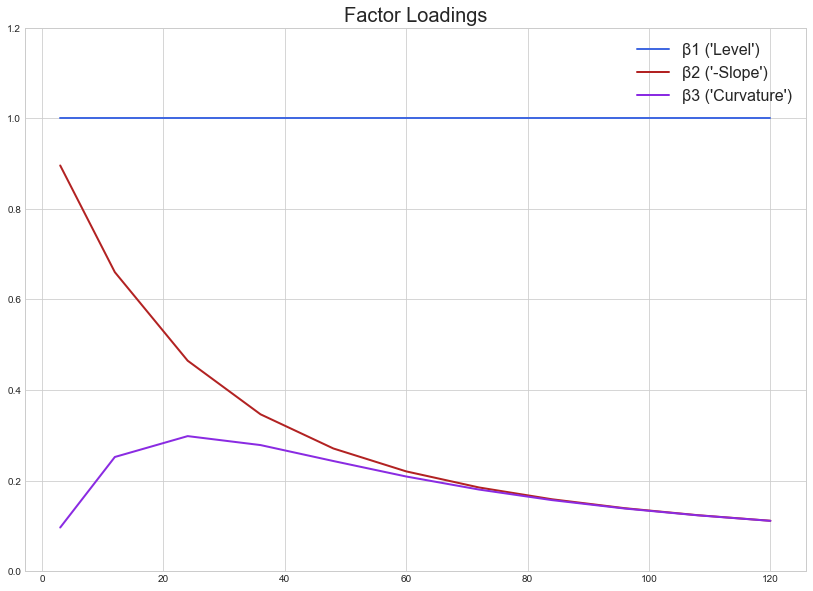

In [420]:
loadings_plot()

#### Yield Curve Estimation

The main estimation equation follows:

<font size='4'>

$
y_t(\tau) = \beta_{1t}(1) + \beta_{2t}\left(\frac{1 - e^{-\lambda_t\tau}}{\lambda_t\tau}\right) + \beta_{3t}\left(\frac{1 - e^{-\lambda_t\tau}}{\lambda_t\tau} - e^{-\lambda_t\tau}\right)
$
        
</font>

For each $\tau$. However this can be arranged in matrix notation for ease of implementation:

<font size='4'>
$
\begin{bmatrix} y^{3m}\\ ... \\ y^{120m} \\ \end{bmatrix}_t = 
    \begin{bmatrix} 1 & \left(\frac{1 - e^{-\lambda_t3}}{\lambda_t3}\right) & \left(\frac{1 - e^{-\lambda_t3}}{\lambda_t3} - e^{-\lambda_t3}\right) \\ 
                    1 & \left(\frac{1 - e^{-\lambda_t12}}{\lambda_t12}\right) & \left(\frac{1 - e^{-\lambda_t12}}{\lambda_t12} - e^{-\lambda_t12}\right) \\ 
                     & ... &  \\
                    1 & \left(\frac{1 - e^{-\lambda_t120}}{\lambda_t120}\right) & \left(\frac{1 - e^{-\lambda_t120}}{\lambda_t120} - e^{-\lambda_t120}\right) \\
                    \end{bmatrix} 
    \begin{bmatrix} \beta_{1}\\ \beta_{2}\\ \beta_{3} \end{bmatrix}_t + e_t    
$
</font>

Specifically, this is equivalent to running $t$ cross-sectional regressions, where every yield $y(\tau)$ is regressed against the same coefficients (and the factors are backed out).

In [232]:
# Estimation: t cross=sections
factors = []
fitted_curve = []

for t in range(0,len(data)):
    model = sm.OLS(data.iloc[t].values, loadings_df.values)
    results = model.fit()

    factors.append(results.params)
    fitted_curve.append(results.predict())
    
factors = pd.DataFrame(factors, index=data.index)
factors.columns = ['B1','B2','B3']
fitted_curve = pd.DataFrame(fitted_curve, index=data.index)
fitted_curve.columns = data.columns.values + "_hat"

#### Plots

##### Factors

In [413]:
def plot_factors(data=data, factors=factors):
    '''
    Plots factors as well as yield curve characteristics from actual yields.
    Replication of Figure 7 from Diebold & Li (2006)
    '''
    data = data/100
    level = data['y120']
    slope = data['y120'] - data['y3']
    curvature = 2*data['y24'] - data['y120'] - data['y3']
    factors = factors/100
    
    
    fig, ax = plt.subplots(3, 1, figsize=(14,12))

    ax1 = level.plot(ax=ax[0], legend=True,label="Level (10y)", color='royalblue', linewidth=2)
    ax1 = factors["B1"].plot(ax=ax[0], legend=True, label="\u03B21", color='firebrick', linewidth=2)
    ax1.set_title("Level and Factor 1", fontsize=20)
    ax1.legend(fontsize=16)
    ax1.set_xlabel("")
    ax1.set_yticks(ax1.get_yticks())
    y_labels = ax1.get_yticks()
    ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])

    ax2 = slope.plot(ax=ax[1], legend=True,label="Slope (10y-3m)", color='royalblue', linewidth=2)
    ax2 = (-factors["B2"]).plot(ax=ax[1], legend=True, label="-\u03B22", color='firebrick', linewidth=2)
    ax2.set_title("Slope and -Factor 2", fontsize=20)
    ax2.legend(fontsize=16)
    ax2.set_xlabel("")
    ax2.set_yticks(ax2.get_yticks())
    y_labels = ax2.get_yticks()
    ax2.set_yticklabels([f'{x:0.1%}' for x in y_labels])

    ax3 = curvature.plot(ax=ax[2], legend=True,label="Curvature (2x2y - 10y - 3m)", color='royalblue', linewidth=2)
    ax3 = (0.3*factors["B3"]).plot(ax=ax[2], legend=True, label="0.3\u03B23", color='firebrick', linewidth=2)
    ax3.set_title("Curvature and Factor 3", fontsize=20)
    ax3.legend(fontsize=16)
    ax3.set_xlabel("")
    ax3.set_yticks(ax3.get_yticks())
    y_labels = ax3.get_yticks()
    ax3.set_yticklabels([f'{x:0.1%}' for x in y_labels])

    fig.tight_layout()
    plt.show()
    

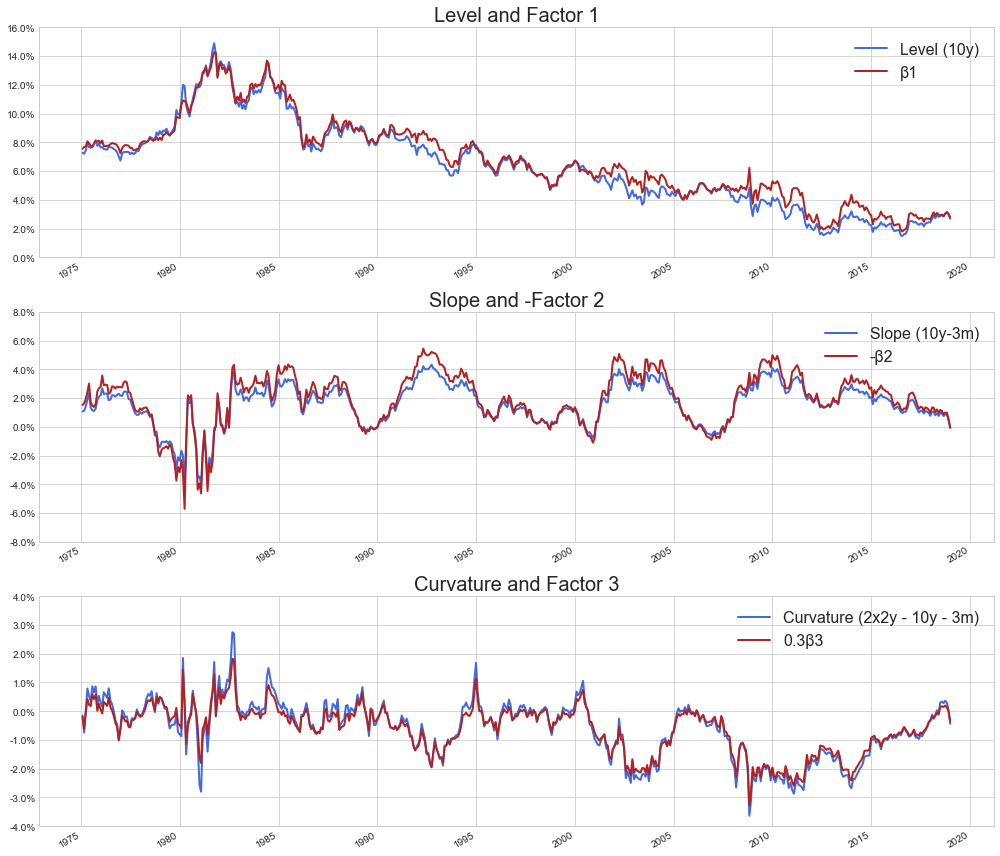

In [414]:
plot_factors()

##### Yield Fit (Time-Series)

In [415]:
def plot_yield(maturity, y=data, y_hat=fitted_curve):
    '''
    Plots the time-series of a yield for a particular maturity (in months) and the fitted values. 
    '''
    yield_curve = pd.merge(data, fitted_curve, left_index=True, right_index=True)/100
    yield_curve['error'] = yield_curve["y"+str(int(maturity))] - yield_curve["y"+str(int(maturity))+"_hat"]
    
    fig, ax = plt.subplots(2, 1, figsize=(16,8), gridspec_kw={'height_ratios': [3,1]})

    ax1 = yield_curve["y"+str(int(maturity))].plot(ax=ax[0], legend=True,label="Actual", color='royalblue', linewidth=2)
    ax1 = yield_curve["y"+str(int(maturity))+"_hat"].plot(ax=ax[0], legend=True, label="Fitted", color='firebrick', linewidth=2)
    ax1.set_title(str(int(maturity))+" Month Yield", fontsize=20)
    ax1.legend(fontsize=16)
    ax1.set_xlabel("")
    ax1.set_yticks(ax1.get_yticks())
    y_labels = ax1.get_yticks()
    ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])

    
    ax2 = yield_curve["error"].plot(ax=ax[1], color='mediumslateblue', linewidth=2)
    ax2.set_title("Difference", fontsize=20)
    ax2.set_xlabel("")
    ax2.set_yticks(ax2.get_yticks())
    y_labels = ax2.get_yticks()
    ax2.set_yticklabels([f'{100*100*x:0.0f}bps' for x in y_labels])
    
    fig.tight_layout()
    plt.show()

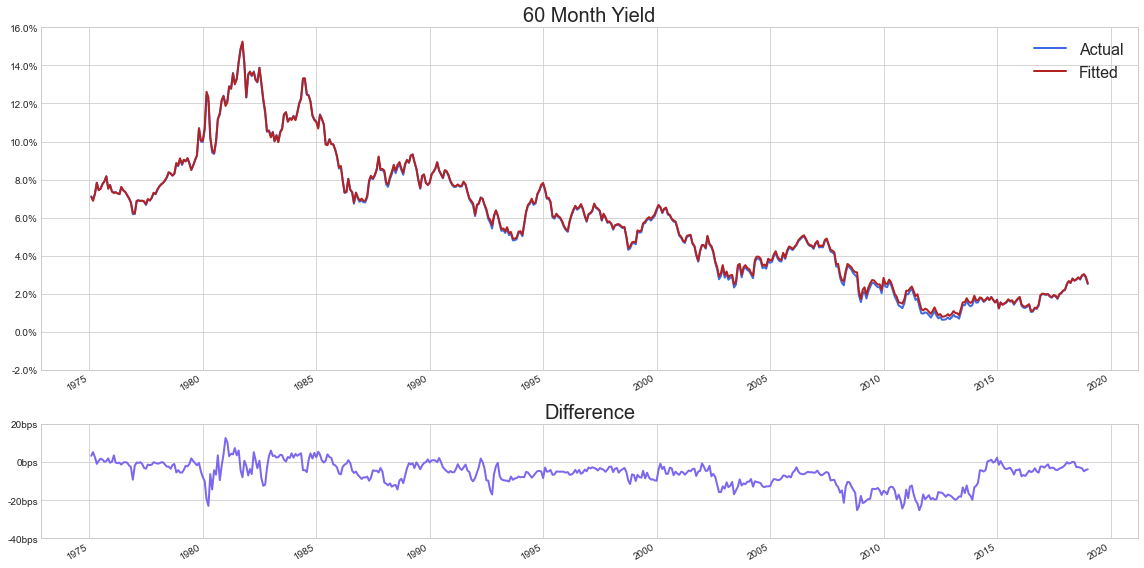

In [416]:
plot_yield(maturity=60)

##### Yield Curve Fit (Cross-Section)

In [417]:
def plot_yield_curve(date, y=data, y_hat=fitted_curve):
    '''
    Plots the actual and fitted yield curve for a specific month. 
    '''
    fitted = fitted_curve.loc[date].iloc[0]
    fitted.index = data.columns.values
    yield_curve = pd.merge(data.loc[date].iloc[0], fitted, left_index=True, right_index=True)/100
    yield_curve.columns = ['Actual', "Fitted"]
    
    fig, ax = plt.subplots(figsize=(16,8))

    ax = yield_curve["Actual"].plot(ax=ax, legend=True,label="Actual", color='royalblue', linewidth=2)
    ax = yield_curve["Fitted"].plot(ax=ax, legend=True, label="Fitted", color='firebrick', linewidth=3, linestyle='dotted')
    ax.set_title("Yield Curve as of "+date, fontsize=20)
    ax.legend(fontsize=16)
    ax.set_xlabel("")
    ax.set_yticks(ax.get_yticks())
    y_labels = ax.get_yticks()
    ax.set_yticklabels([f'{x:0.1%}' for x in y_labels])

    fig.tight_layout()
    plt.show()

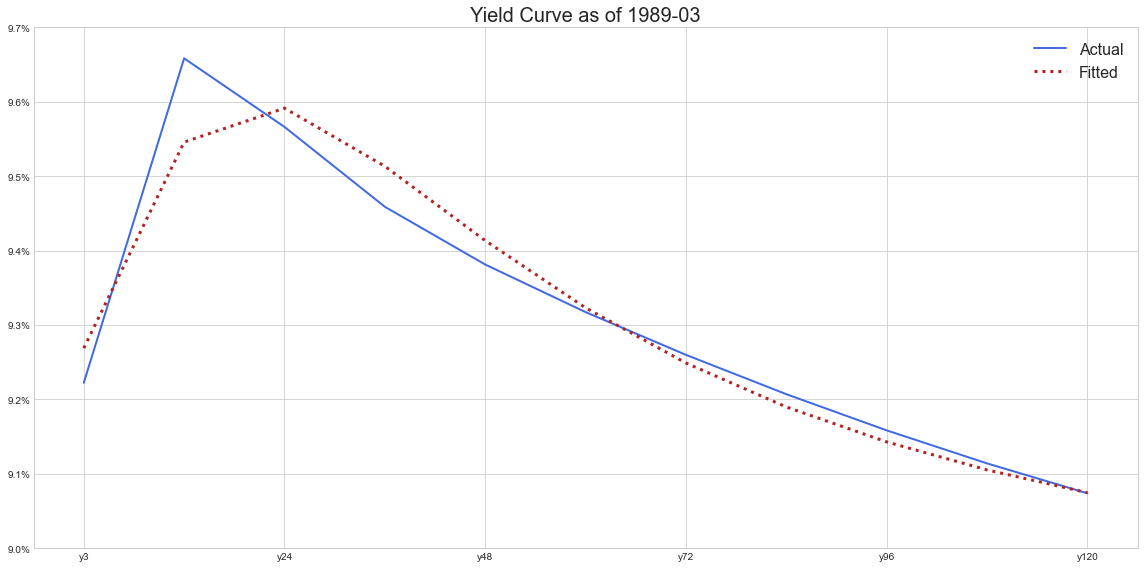

In [418]:
plot_yield_curve('1989-03')

### Rotating the Yield Curve Factors

### Modeling and Forecasting Yield Curve Factors